In [1]:
from catboost import CatBoostRegressor
from utils.load import load_data, load_submission
from utils.feature import (
    add_hours,
    add_hours_trig_cyclic,
    apply_feature_engineering,
    get_dummies,
    fill_na_zero,
    drop_non_input_cols,
    normalize,
    standardize,
    sort_by_time
)
from utils.model import ModelEvalWrapper

In [2]:
train_df, predict_df = load_data('../data')

In [3]:
_train_df, _predict_df = apply_feature_engineering(
    train_df,
    predict_df,
    funcs=[
        add_hours,
        fill_na_zero("all"),
        normalize(["txpower_cell0", "txpower_cell1", "txpower_cell2", "txpower_cell3"]),
        normalize(
            [
                "bandwidth_cell0",
                "antennas_cell0",
                "bandwidth_cell1",
                "antennas_cell1",
                "bandwidth_cell2",
                "antennas_cell2",
                "bandwidth_cell3",
                "antennas_cell3",
            ]
        ),
        get_dummies(
            [
                "hour",
                "rutype",
                "mode",
                # "frequency_cell0",
                # "frequency_cell1",
                # "frequency_cell2",
                # "frequency_cell3",
            ]
        ),
        # sort_by_time,
        drop_non_input_cols,
    ],
)

In [4]:
params = {
    "iterations": 10000,
    "learning_rate": 0.01,
    "depth": 6,
    "loss_function": "MAE",
}

model_getter = lambda: CatBoostRegressor(**params)
model_trainer = lambda model, X, y, *args, **kwargs: model.fit(
    X, y, verbose=False, eval_set=(kwargs["X_test"], kwargs["y_test"])
)
model_predictor = lambda model, X: model.predict(X)
model_eval = ModelEvalWrapper(
    model_getter,
    name="CatBoost",
    model_trainer=model_trainer,
    model_predictor=model_predictor,
    kfolds=5
)

model_eval.train_and_eval(_train_df)


INFO:root:Fold 1/5
INFO:root:Train MAE: 2.3769, MAPE: 0.0844, MSE: 13.3585
INFO:root:Test MAE: 2.4475, MAPE: 0.0874, MSE: 13.9602
INFO:root:Fold 2/5
INFO:root:Train MAE: 2.3865, MAPE: 0.0846, MSE: 13.4893
INFO:root:Test MAE: 2.4132, MAPE: 0.0849, MSE: 13.6775
INFO:root:Fold 3/5
INFO:root:Train MAE: 2.3772, MAPE: 0.0841, MSE: 13.4527
INFO:root:Test MAE: 2.4484, MAPE: 0.0870, MSE: 13.9462
INFO:root:Fold 4/5
INFO:root:Train MAE: 2.3832, MAPE: 0.0844, MSE: 13.5111
INFO:root:Test MAE: 2.4209, MAPE: 0.0863, MSE: 13.6030
INFO:root:Fold 5/5
INFO:root:Train MAE: 2.3809, MAPE: 0.0847, MSE: 13.4254
INFO:root:Test MAE: 2.4295, MAPE: 0.0859, MSE: 13.7268
INFO:root:
Best model from fold 2
INFO:root:Best model mae: 2.4132, mape: 0.0849 mse: 13.6775

INFO:root:Average mae: 2.4319, mape: 0.0863, mse: 13.7827
INFO:root:Std mae: 0.0141, mape: 0.0009, mse: 0.1447

INFO:root:Analytic evaluations for best model
INFO:root:Error metrics by number of cells in usage
INFO:root:Metrics for 0 cells in usage (87225

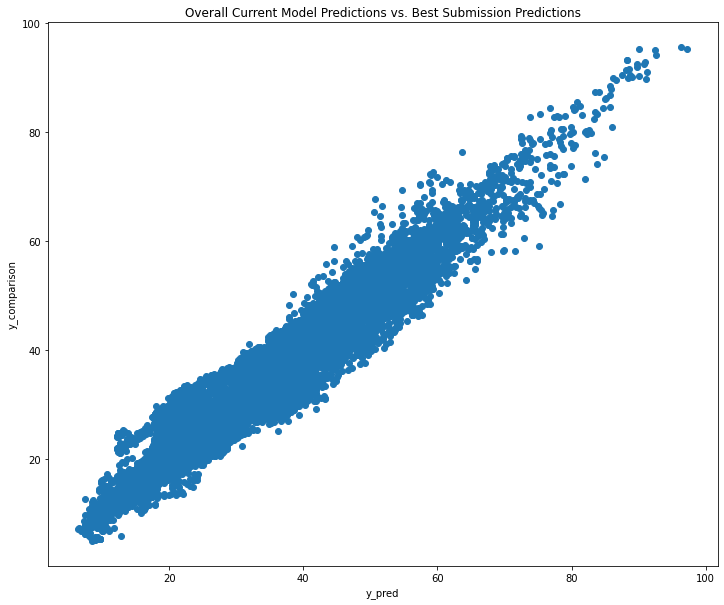

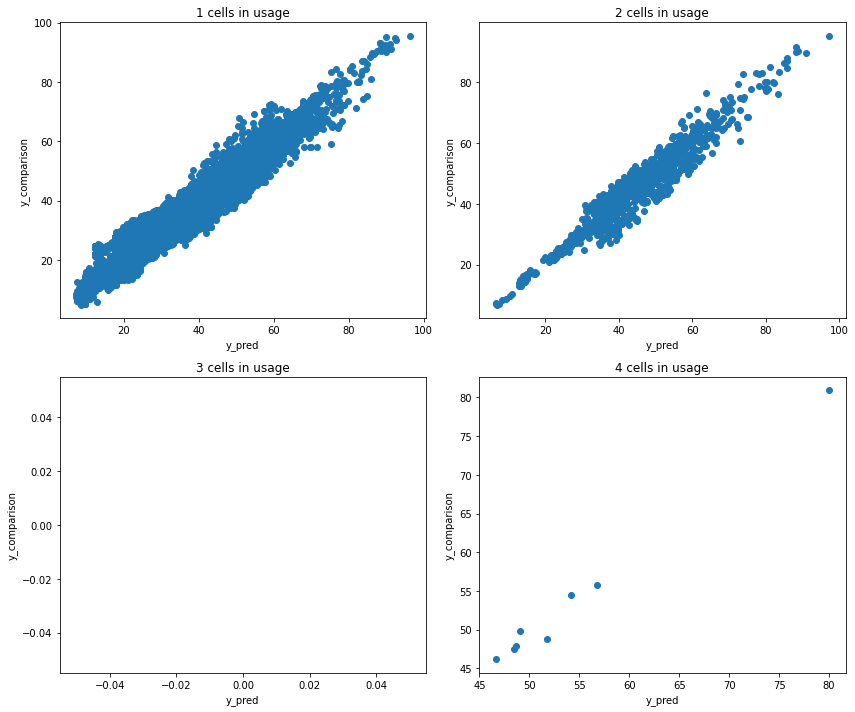

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 10)
best_submission = load_submission("bestsubmission.csv")
model_eval.compare_predictions_with(_predict_df, best_submission['Energy'])